In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import _pickle as cPickle
import gzip
import joblib

from collections import Counter

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import permutation_test_score, StratifiedKFold

def warn(*args, **kwargs):
    pass
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%reload_ext autoreload
%autoreload 2
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [40]:
consensus_descriptors_hits = pd.read_excel('../dataset/screened/pubchem_hits_descriptors_consensus.xlsx')
print(consensus_descriptors_hits.shape)
consensus_descriptors_hits.head()

(101097, 22)


,Unnamed: 0,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,svm_score,mlp,mlp_ad,...,tf_ad,tf_score,consensus_morgan,consensus_morgan_ad,count,consensus_sirms,consensus_sirms_ad,consensus_rdkit,consensus_rdkit_ad,count_ad
0,90626,88374080,3,3,309.40,3.1,O=C(NCNC1CCCNC1c1ccccc1)c1ccccc1,0.94,1,1.0,...,1.0,0.96,1.0,1.0,3,1.0,1.0,1.0,1.0,3
1,127922,46555856,1,2,286.37,2.4,CNC(=O)c1ccc(C=CC(=O)N2CCCC(C)C2)cc1,0.72,1,1.0,...,1.0,0.98,1.0,1.0,3,1.0,1.0,1.0,1.0,3
2,127881,46465375,2,3,393.50,3.5,Cc1ccccc1C(=O)NCC(=O)NCc1ccc(CN2CCCC(C)C2)cc1,0.93,1,1.0,...,1.0,0.91,1.0,1.0,3,1.0,1.0,1.0,1.0,3
3,26036,51192106,0,3,328.40,2.3,Cc1ccc2c(c1)C(=O)N(CCCC(=O)N1CCCC(C)C1)C2=O,0.54,1,1.0,...,1.0,0.71,1.0,1.0,3,1.0,1.0,1.0,1.0,3
4,55594,24547858,2,3,381.50,3.3,CCCC(NC(=O)CCn1c(=S)[nH]c2ccccc2c1=O)c1ccccc1,0.97,1,1.0,...,1.0,0.89,1.0,1.0,3,1.0,1.0,1.0,1.0,3


In [41]:
similarity_hits = pd.read_excel('../similarity/screened_compounds/pubchem_hits_similarity_search_all.xlsx')
print(similarity_hits.shape)
similarity_hits.head()

(101097, 12)


,Unnamed: 0,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES,HitFreq,Include,Nearest Neighbor,Similarity
0,36235.0,3876660.0,1.0,3.0,380.50,4.3,COC1=C(C=C2C(=C1)CC(C2=O)CC3CC[NH+](CC3)CC4=CC...,COC1=C(C=C2C(=C1)CC(C2=O)CC3CC[NH+](CC3)CC4=CC...,14.0,1.0,Donepezil,1.0
1,70940.0,9651.0,1.0,4.0,287.35,1.8,CN1CCC23C=CC(CC2OC4=C(C=CC(=C34)C1)OC)O,CN1CC[C@@]23C=C[C@@H](C[C@@H]2OC4=C(C=CC(=C34)...,11.0,1.0,Galantamine,1.0
2,70971.0,11860544.0,2.0,3.0,288.36,1.8,C[NH+]1CCC23C=CC(CC2OC4=C(C=CC(=C34)C1)OC)O,C[NH+]1CC[C@@]23C=C[C@@H](C[C@@H]2OC4=C(C=CC(=...,8.0,1.0,Galantamine,1.0
3,71075.0,163433877.0,1.0,3.0,288.36,1.8,CN1CCC23C=CC(CC2OC4=C(C=CC(=C34)C1)OC)[OH2+],CN1CC[C@]23C=C[C@@H](C[C@@H]2OC4=C(C=CC(=C34)C...,11.0,1.0,Galantamine,1.0
4,71328.0,70125947.0,1.0,4.0,315.40,2.7,CCCOC1=C2C3=C(CN(CCC34C=CC(CC4O2)O)C)C=C1,CCCOC1=C2C3=C(CN(CC[C@]34C=C[C@@H](C[C@@H]4O2)...,11.0,1.0,Galantamine,1.0


In [47]:
merged = consensus_descriptors_hits.merge(similarity_hits[['CID', 'Nearest Neighbor', 'Similarity', 'IsomericSMILES']], on='CID', how='inner')


merged

,Unnamed: 0,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,svm_score,mlp,mlp_ad,...,consensus_morgan_ad,count,consensus_sirms,consensus_sirms_ad,consensus_rdkit,consensus_rdkit_ad,count_ad,Nearest Neighbor,Similarity,IsomericSMILES
0,90626,88374080,3,3,309.40,3.1,O=C(NCNC1CCCNC1c1ccccc1)c1ccccc1,0.94,1,1.0,...,1.0,3,1.0,1.0,1.0,1.0,3,Donepezil,0.300407,C1C[C@@H]([C@@H](NC1)C2=CC=CC=C2)NCNC(=O)C3=CC...
1,127922,46555856,1,2,286.37,2.4,CNC(=O)c1ccc(C=CC(=O)N2CCCC(C)C2)cc1,0.72,1,1.0,...,1.0,3,1.0,1.0,1.0,1.0,3,Donepezil,0.265695,CC1CCCN(C1)C(=O)/C=C/C2=CC=C(C=C2)C(=O)NC
2,127881,46465375,2,3,393.50,3.5,Cc1ccccc1C(=O)NCC(=O)NCc1ccc(CN2CCCC(C)C2)cc1,0.93,1,1.0,...,1.0,3,1.0,1.0,1.0,1.0,3,Donepezil,0.331089,CC1CCCN(C1)CC2=CC=C(C=C2)CNC(=O)CNC(=O)C3=CC=C...
3,26036,51192106,0,3,328.40,2.3,Cc1ccc2c(c1)C(=O)N(CCCC(=O)N1CCCC(C)C1)C2=O,0.54,1,1.0,...,1.0,3,1.0,1.0,1.0,1.0,3,Donepezil,0.355224,CC1CCCN(C1)C(=O)CCCN2C(=O)C3=C(C2=O)C=C(C=C3)C
4,55594,24547858,2,3,381.50,3.3,CCCC(NC(=O)CCn1c(=S)[nH]c2ccccc2c1=O)c1ccccc1,0.97,1,1.0,...,1.0,3,1.0,1.0,1.0,1.0,3,Galantamine,0.392529,CCCC(C1=CC=CC=C1)NC(=O)CCN2C(=O)C3=CC=CC=C3NC2=S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101092,64335,3591937,0,2,232.36,2.7,CC(C)(C)N1CCN(Cc2ccccc2)CC1,0.58,0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0,Rivastigmine,0.232465,CC(C)(C)N1CCN(CC1)CC2=CC=CC=C2
101093,88270,79156496,1,2,289.40,2.5,CCCNC1CCN(C(=O)N(CC)CC)c2ccccc21,0.64,0,NaN,...,0.0,0,0.0,0.0,NaN,0.0,0,Galantamine,0.376721,CCCNC1CCN(C2=CC=CC=C12)C(=O)N(CC)CC
101094,64336,3466189,0,1,177.29,2.9,CCN(CC)C(C)c1ccccc1,0.73,0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0,Rivastigmine,0.352018,CCN(CC)C(C)C1=CC=CC=C1
101095,121238,113167583,1,3,312.40,2.5,COc1cccc(NC(=O)CN(C(C)=O)c2cccc(C)c2)c1,0.79,1,NaN,...,1.0,0,0.0,0.0,0.0,0.0,1,Galantamine,0.243952,CC1=CC(=CC=C1)N(CC(=O)NC2=CC(=CC=C2)OC)C(=O)C


In [53]:
hits = merged[merged['count_ad'] == 3.0] 
hits = hits[merged['Similarity'] >= 0.95] 
print(hits.shape)
hits

(29, 25)


,Unnamed: 0,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,svm_score,mlp,mlp_ad,...,consensus_morgan_ad,count,consensus_sirms,consensus_sirms_ad,consensus_rdkit,consensus_rdkit_ad,count_ad,Nearest Neighbor,Similarity,IsomericSMILES
1921,36235,3876660,1,3,380.50,4.3,COc1cc2c(cc1OC)C(=O)C(CC1CC[NH+](Cc3ccccc3)CC1)C2,0.67,1,1.0,...,1.0,3,1.0,1.0,1.0,1.0,3,Donepezil,1.000000,COC1=C(C=C2C(=C1)CC(C2=O)CC3CC[NH+](CC3)CC4=CC...
4570,36060,10045400,0,4,381.50,4.6,CCN(CCCCC1Cc2cc(OC)c(OC)cc2C1=O)Cc1ccccc1,0.51,1,1.0,...,1.0,2,1.0,1.0,1.0,1.0,3,Donepezil,0.962963,CCN(CCCCC1CC2=CC(=C(C=C2C1=O)OC)OC)CC3=CC=CC=C3
4648,36812,4176841,0,5,393.50,4.0,COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2=O,0.93,1,1.0,...,1.0,2,1.0,1.0,1.0,1.0,3,Donepezil,0.965563,COC1=C(C=C2C(=C1)C(=O)C(C2=O)CC3CCN(CC3)CC4=CC...
8034,35961,10620599,0,4,393.50,4.6,COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3C)CC1)C2,0.68,1,NaN,...,1.0,2,NaN,1.0,1.0,1.0,3,Donepezil,0.959211,CC1=CC=CC=C1CN2CCC(CC2)CC3CC4=CC(=C(C=C4C3=O)O...
24144,135423,2281160,1,2,242.36,4.6,CCCCc1nc2ccccc2c(N)c1CCC,0.72,1,1.0,...,1.0,2,1.0,1.0,1.0,1.0,3,Tacrine,0.956284,CCCCC1=NC2=CC=CC=C2C(=C1CCC)N
24191,135461,153896011,1,2,197.26,2.7,[NH-]c1c2c(nc3ccccc13)CCCC2,0.73,1,1.0,...,1.0,2,1.0,1.0,1.0,1.0,3,Tacrine,1.000000,C1CCC2=NC3=CC=CC=C3C(=C2C1)[NH-]
48547,36643,59318325,0,4,393.50,4.7,COc1cc2c(cc1OC)C(=O)C(C(C)C1CCN(Cc3ccccc3)CC1)C2,0.84,0,0.0,...,1.0,1,NaN,1.0,1.0,1.0,3,Donepezil,0.950456,CC(C1CCN(CC1)CC2=CC=CC=C2)C3CC4=CC(=C(C=C4C3=O...
48561,36752,10309580,0,4,393.50,4.6,CCOc1cc2c(cc1OC)CC(CC1CCN(Cc3ccccc3)CC1)C2=O,0.76,0,NaN,...,1.0,1,NaN,1.0,1.0,1.0,3,Donepezil,0.952941,CCOC1=C(C=C2CC(C(=O)C2=C1)CC3CCN(CC3)CC4=CC=CC...
48563,36772,10194189,0,4,393.50,4.6,CCOc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2,0.70,0,NaN,...,1.0,1,NaN,1.0,1.0,1.0,3,Donepezil,0.955439,CCOC1=C(C=C2C(=C1)CC(C2=O)CC3CCN(CC3)CC4=CC=CC...
61469,71494,58645895,1,4,385.50,2.4,COc1ccc2c3c1OC1CC(O)C=CC31CC[N+](C)(CCN1CCCC1)C2,1.00,1,1.0,...,1.0,1,NaN,1.0,NaN,1.0,3,Galantamine,0.967096,C[N+]1(CC[C@@]23C=C[C@@H](C[C@@H]2OC4=C(C=CC(=...


In [68]:
with pd.ExcelWriter('../dataset/screened/pubchem_hits_consensus_final.xlsx') as writer:
    merged.to_excel(writer, sheet_name='consensus', index=False)

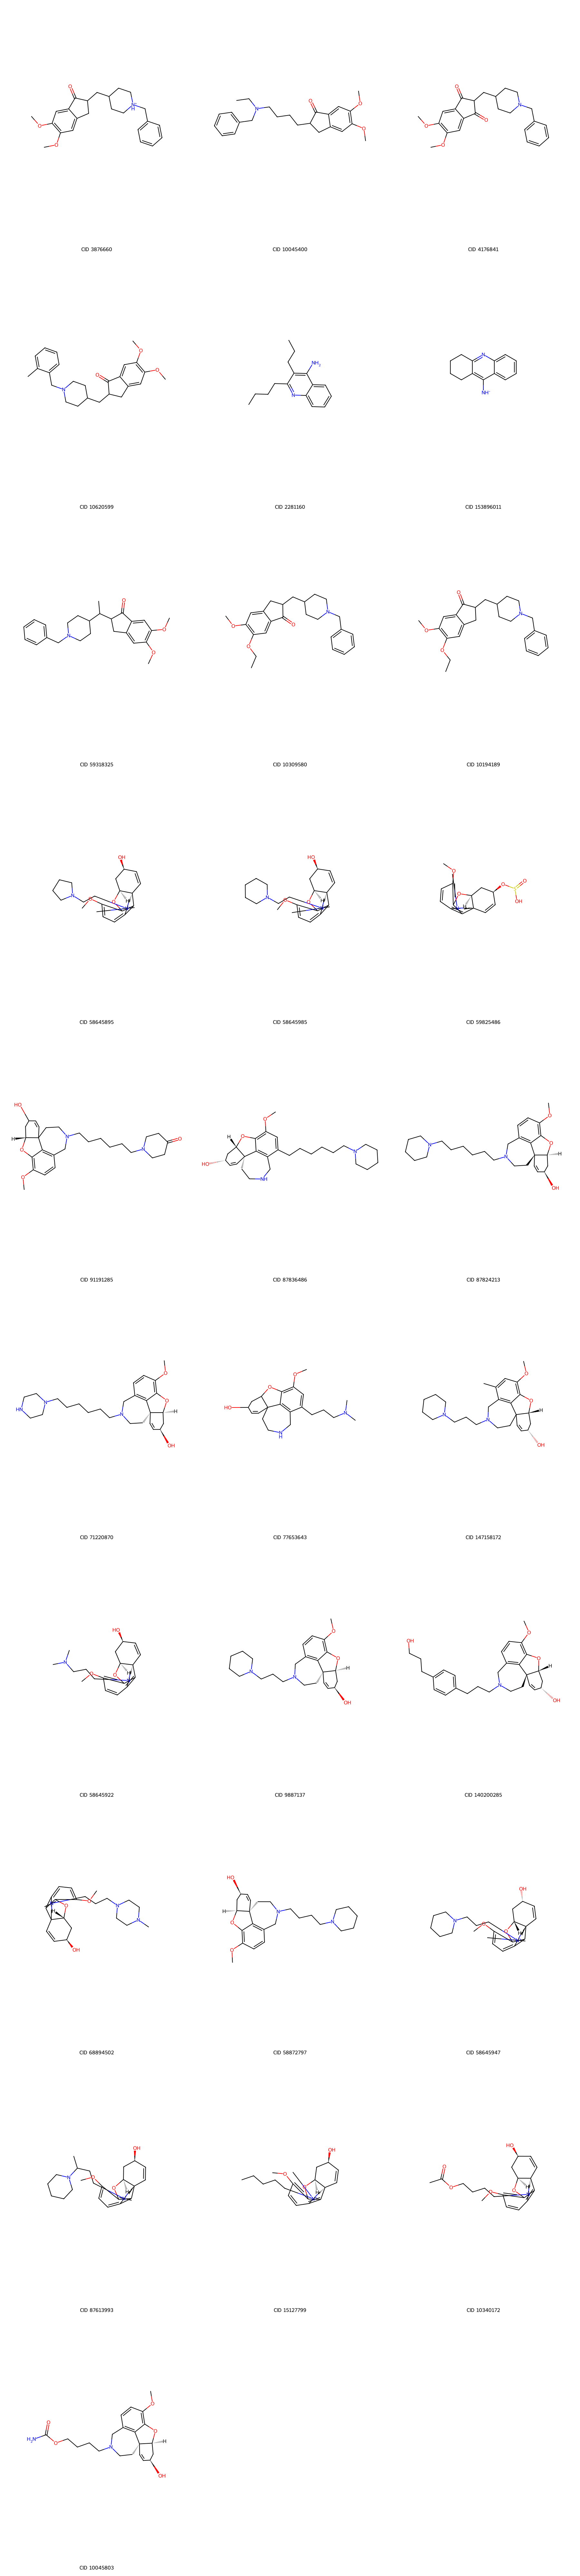

In [80]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

fplist = [Chem.MolFromSmiles(smi) for smi in hits['IsomericSMILES'].shift().dropna()]

# Criar legendas no formato 'CID x'
mylegends = ['CID ' + str(cid) for cid in hits['CID']]

# Agora, você pode criar a imagem com as legendas atualizadas
img = Draw.MolsToGridImage(fplist, molsPerRow=3, subImgSize=(600, 800), legends=mylegends)
display(img)